In [ ]:
!pip install matplotlib numpy pillow opencv-python --no-index
!pip install scikit-learn tensorboard pytorch-lightning comet-ml --no-index
!pip install --upgrade --force-reinstall torch torchvision --no-index

## Imports and Utils

In [3]:
import torch
import os
import cv2
import random
import numpy as np

from PIL import Image
from glob import glob
from tqdm import tqdm, trange
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import json
import pytorch_lightning as pl
import sys

from lit_model import lit_gazetrack_model

from model import gazetrack_model
from gazetrack_data import gazetrack_dataset

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor

root = os.environ['SLURM_TMPDIR']

In [4]:
import colorsys
def get_colors(num_colors):
    colors=[]
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() * 10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

def euc(a, b):
    return np.sqrt(np.sum(np.square(a - b), axis=1))

In [33]:
def make_img(fname):
    img1 = plt.imread(glob(fname+"*.jpg")[np.random.randint(len(glob(fname+"*.jpg")))])
    img2 = plt.imread(glob(fname+"*.jpg")[np.random.randint(len(glob(fname+"*.jpg")))])
    img3 = plt.imread(glob(fname+"*.jpg")[np.random.randint(len(glob(fname+"*.jpg")))])
    img4 = plt.imread(glob(fname+"*.jpg")[np.random.randint(len(glob(fname+"*.jpg")))])
    col = np.zeros((img1.shape[0]*2, img1.shape[1]*2, img1.shape[2]))
    print(col.shape)
    col[0:img1.shape[0], 0:img1.shape[1], :] = img1
    col[0:img1.shape[0], img1.shape[1]:img1.shape[1]*2, :] = img3
    
    col[img1.shape[0]:img1.shape[0]*2, 0:img1.shape[1], :] = img2
    col[img1.shape[0]:img1.shape[0]*2, img1.shape[1]:img1.shape[1]*2, :] = img4
    return col/255.

def plot_pts(fname, gt, preds, pts, c, title, cent=False):
    
    cols = np.zeros((len(gt),3))
    cents = np.zeros_like(preds)
    
    for i in range(len(pts)):
        cols[np.where(np.all(gt==pts[i], axis=1))] = c[i]
        if(cent):
            cents[np.where(np.all(gt==pts[i], axis=1))] = np.mean(preds[np.where(np.all(gt==pts[i], axis=1))], axis=0)
    
    plt.figure(figsize=(24,12))
    plt.subplot(1,2,1)
    plt.imshow(make_img(fname))
    plt.subplot(1,2,2)
    plt.title(title)
    plt.grid(color='gray', linestyle='dashed')
    plt.scatter(0, 0, marker='*', s=200, label="Camera")
    plt.scatter(preds[:,0], preds[:,1], c=cols, s=10, label="Model predictions")
    plt.scatter(gt[:,0], gt[:,1], c=cols, marker='+', s=200, label="Ground truth locations")
    if(cent):
        plt.scatter(cents[:,0], cents[:,1], c=cols, marker='1',s=100, label="Predictions centroid")
    plt.xlabel('distance from the camera at origin in x direction (cm)')
    plt.ylabel('distance from the camera at origin in y direction (cm)')
    plt.axis('scaled')
    plt.xlim(-2.5, 4)
    plt.ylim(-13, 0.2)
    plt.legend()
    
def plot_comp(gt, preds1, preds2, pts, c, title=['', ''], cent='none', lines=False):
    cols = np.zeros((len(gt),3))
    cents1 = np.zeros_like(preds1)
    cents2 = np.zeros_like(preds2)
    for i in range(len(pts)):
        cols[np.where(np.all(gt==pts[i],axis=1))] = c[i]
        if(cent):
            cents1[np.where(np.all(gt==pts[i], axis=1))] = np.mean(preds1[np.where(np.all(gt==pts[i], axis=1))], axis=0)
            cents2[np.where(np.all(gt==pts[i], axis=1))] = np.mean(preds2[np.where(np.all(gt==pts[i], axis=1))], axis=0)
    
    f, axes = plt.subplots(1, 3, sharex='all', sharey='all', figsize=(22,11))
    f.patch.set_facecolor('white')
    ax1, ax2, ax3 = axes
    ax1.set_title(title[0])
    ax1.grid(color='gray', linestyle='dashed')
    ax1.scatter(0, 0, marker='*', s=200, label='Camera')
    if(cent=='none' or cent=='both'):
        ax1.scatter(preds1[:,0], preds1[:,1], c=cols, s=10, label="Base Model Predictions")
    ax1.scatter(gt[:,0], gt[:,1], c=cols, marker='+', s=200, label="Ground Truths")
    if(cent=='both' or cent=='only'):
        ax1.scatter(cents1[:,0], cents1[:,1], c=cols, marker='1', s=70, label="Base Model Prediction Centroids")
    ax1.set_xlabel('distance from the camera at origin in x direction (cm)')
    ax1.set_ylabel('distance from the camera at origin in y direction (cm)')    
    ax1.set_xlim([-3, 5])
    ax1.set_ylim([-12, 0.5])
    ax1.set_aspect('equal')
    
    ax2.set_title(title[1])
    ax2.grid(color='gray', linestyle='dashed')
    ax2.scatter(0, 0, marker='*', s=200, label='Camera')
    if(cent=='none' or cent=='both'):
        ax2.scatter(preds2[:,0], preds2[:,1], c=cols, s=10, label="SVR Predictions")
    ax2.scatter(gt[:,0], gt[:,1], c=cols, marker='+', s=200, label="Ground Truths")
    if(cent=='both' or cent=='only'):
        ax2.scatter(cents2[:,0], cents2[:,1], c=cols, marker='1', s=70, label="SVR Prediction Centroids")
    ax2.set_xlabel('distance from the camera at origin in x direction (cm)')
    ax2.set_ylabel('distance from the camera at origin in y direction (cm)')
    ax2.set_xlim([-3, 5])
    ax2.set_ylim([-12, 0.5])
    ax2.set_aspect('equal')

    ############## LINES #########
    
    if(lines):        
        ax3.set_title("Movement of points")
        ax3.grid(color='gray', linestyle='dashed')
        ax3.scatter(0, 0, marker='*', s=200, label='Camera')
        if(cent=='none' or cent=='both'):
            ax3.scatter(preds1[:,0], preds1[:,1], c=cols, s=10, label="Base Model Predictions")
            ax3.scatter(preds2[:,0], preds2[:,1], c=cols, marker="p", s=30, label="SVR Predictions")
        if(cent=='both' or cent=='only'):
            ax3.scatter(cents1[:,0], cents1[:,1], c=cols, marker='1', s=70, label="Base Model Prediction Centroids")
            ax3.scatter(cents2[:,0], cents2[:,1], c=cols, marker='p', s=70, label="SVR Prediction Centoids")

        for i in range(len(preds1)):
            if(cent=='none' or cent=='both'):
                ax3.plot([preds1[i][0], preds2[i][0]], [preds1[i][1], preds2[i][1]], c=cols[i], linewidth=0.5)
            if(cent=='only' or cent=='both'):
                ax3.plot([cents1[i][0], cents2[i][0]], [cents1[i][1], cents2[i][1]], c=cols[i], linewidth=0.5)

        ax3.scatter(gt[:,0], gt[:,1], c=cols, marker='+', s=200)
        ax3.set_xlabel('distance from the camera at origin in x direction (cm)')
        ax3.set_ylabel('distance from the camera at origin in y direction (cm)')
        ax3.axis('scaled')
        ax3.set_xlim([-3, 5])
        ax3.set_ylim([-12, 0.5])
        ax3.set_aspect('equal')
        ax3.legend(loc=3)
        ax2.legend(loc=3)
        ax1.legend(loc=3)
        plt.show()

## Load model and weights

In [6]:
f = root+'/svr13_gt_fin/test/images/'
weight_file = '../Checkpoints/GoogleCheckpoint_MITSplit.ckpt'
print(weight_file)
print(f, len(glob(f+'*.jpg')))

../Checkpoints/GoogleCheckpoint_MITSplit.ckpt
/localscratch/dssr.24194720.0/svr13_gt_fin/test/images/ 33674


In [7]:
model = gazetrack_model()
w = torch.load(weight_file)['state_dict']
model.cuda()
model.load_state_dict(w)
model.eval()

gazetrack_model(
  (eye_model): eye_model(
    (model): Sequential(
      (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (4): Dropout(p=0.02, inplace=False)
      (5): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
      (6): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.01, inplace=True)
      (8): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (9): Dropout(p=0.02, inplace=False)
      (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (12): LeakyReLU(negative_slope=0.01, inplace=True)
      (13): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (14): Dropout(p=0.02, inplace=False)
    )

In [8]:
preds, gt = [], []
ctr = 1
model.eval()
test_dataset = gazetrack_dataset(f, phase='test')
test_dataloader = DataLoader(test_dataset, batch_size=256, num_workers=10, pin_memory=False, shuffle=False,)
for j in tqdm(test_dataloader):
    leye, reye, kps, target = j[1].cuda(), j[2].cuda(), j[3].cuda(), j[4].cuda()
    
    with torch.no_grad():
        pred = model(leye, reye, kps)
    pred = pred.cpu().detach().numpy()
    preds.extend(pred)  
    
    gt.extend(target.cpu().detach().numpy())
    
preds = np.array(preds)

gt = np.array(gt)
dist = euc(preds, gt)
print("Mean Euclidean Distance: ", dist.mean())

  0%|          | 0/132 [00:00<?, ?it/s]

Num files for test = 33674


100%|██████████| 132/132 [00:13<00:00,  9.76it/s]


Mean Euclidean Distance:  1.9187834


## Total Test

In [9]:
all_files = glob(f+"*.jpg")
all_files = [i[:-10] for i in all_files]
files = np.unique(all_files)
print('Found ', len(all_files), ' images from ', len(files), ' subjects.')

fnames = []
nums = []
for i in tqdm(files):
    fnames.append(i)
    nums.append(len(glob(i+"*.jpg")))
fnames = np.array(fnames)
nums = np.array(nums)
ids = np.argsort(nums)
ids = ids[::-1]
fnames_sorted = fnames[ids]
nums_sorted = nums[ids]
files = fnames_sorted.copy()
nums_sorted[0], nums_sorted[-1], sum(nums_sorted)

  0%|          | 0/121 [00:00<?, ?it/s]

Found  33674  images from  121  subjects.


100%|██████████| 121/121 [00:04<00:00, 29.57it/s]


(601, 26, 33674)

In [10]:
total_test = {}
ep = 0

for idx in tqdm(range(len(files))):    
    preds, gt = [], []
    ctr = 1
    f = files[idx]
    test_dataset = gazetrack_dataset(f, phase='test', v=False)
    test_dataloader = DataLoader(test_dataset, batch_size=100, num_workers=10, pin_memory=False, shuffle=False,)

    for j in test_dataloader:
        leye, reye, kps, target = j[1].cuda(), j[2].cuda(), j[3].cuda(), j[4].cuda()

        with torch.no_grad():
            pred = model(leye, reye, kps)
            
        pred = pred.cpu().detach().numpy()
        preds.extend(pred)  

        gt.extend(target.cpu().detach().numpy())

    preds = np.array(preds)
    pts = np.unique(gt, axis=0)

    gt = np.array(gt)
    dist = euc(preds, gt)
    total_test[str(idx)+"_"+str(ep)] = [dist, gt, preds, pts]

mean_errs = []
for i in total_test:
    mean_errs.append(np.mean(total_test[i][0]))
np.mean(mean_errs)

100%|██████████| 121/121 [02:27<00:00,  1.22s/it]


1.9098874

Text(0, 0.5, 'Number of datapoints')

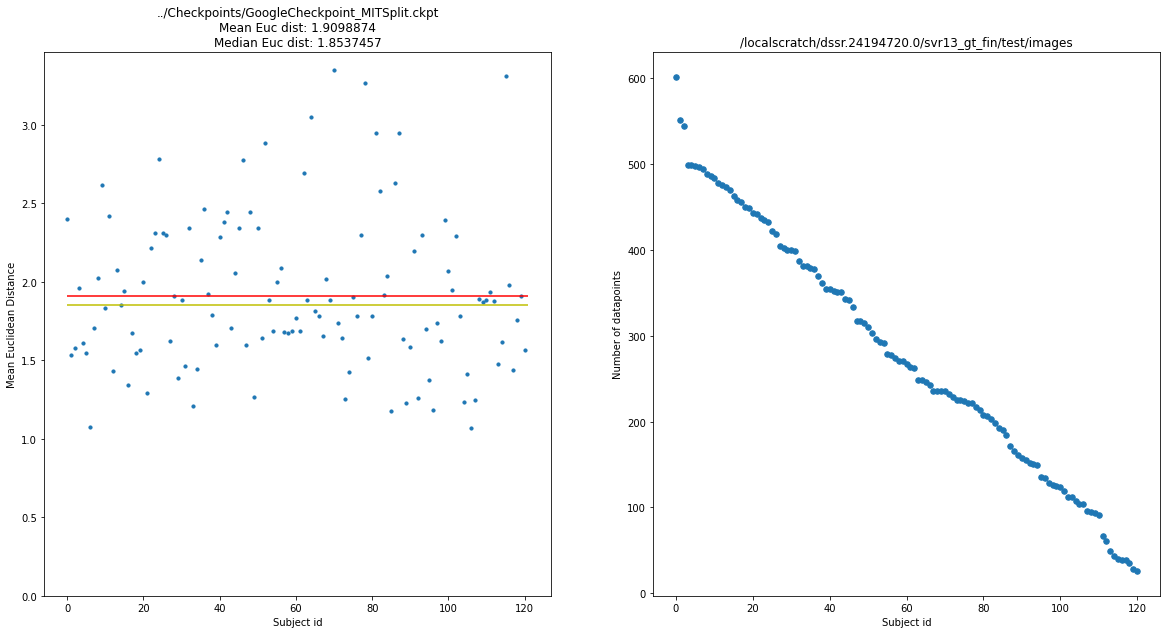

In [11]:
  
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.title(weight_file+"\nMean Euc dist: " +str(np.mean(mean_errs))+"\nMedian Euc dist: " +str(np.median(mean_errs)))
plt.scatter([i for i in range(len(mean_errs))], mean_errs, s=10)
plt.hlines(y=np.mean(mean_errs), xmin=0, xmax=len(mean_errs), color='r')
plt.hlines(y=np.median(mean_errs), xmin=0, xmax=len(mean_errs), color='y')
plt.xlabel('Subject id')
plt.ylabel('Mean Euclidean Distance')
plt.ylim(0)

plt.subplot(1,2,2)
plt.title(files[0][:files[0].rfind('/')])
plt.scatter([i for i in range(len(mean_errs))], [len(total_test[i][0]) for i in total_test], s=30)
plt.xlabel('Subject id')
plt.ylabel('Number of datapoints')


## SVR

In [12]:
# Add hook to [5] for pre ReLU and [6] for after ReLU
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
model.combined_model[6].register_forward_hook(get_activation('out'))

In [17]:
def train_svr(file):
    file = file.replace("test", "train")
    dataset = gazetrack_dataset(file, phase="test", v=False)
    loader = DataLoader(
        dataset,
        batch_size=256,
        num_workers=10,
        pin_memory=False,
        shuffle=False,
    )

    preds, gt, dot_nums = [], [], []
    calib_preds, calib_gt = [], []
    for j in loader:
        leye, reye, kps, target = j[1].cuda(), j[2].cuda(), j[3].cuda(), j[4].cuda()
        with torch.no_grad():
            pred = list(model(leye, reye, kps).cpu().detach().numpy())
        pred = list(activation["out"].detach().cpu().numpy())
        preds = preds + pred
        gt.extend(target.cpu().detach().numpy())

    gt = np.array(gt)
    preds = np.array(preds)
    reg = MultiOutputRegressor(SVR(kernel="rbf", C=20, gamma=0.06))
    
    reg.fit(preds, gt)
    
    return reg


def comp_pred_test_svr(fname, ct=False):
    reg = train_svr(fname)
    
    f = fname.replace("train", "test")
    if ct:
        f = fname
        
    test_dataset = gazetrack_dataset(f, phase="test", v=False)
    test_dataloader = DataLoader(
        test_dataset,
        batch_size=256,
        num_workers=10,
        pin_memory=False,
        shuffle=False,
    )

    preds_pre, preds_final, gt, dot_nums = [], [], [], []
    cent_fin = []

    calib_preds, calib_gt = [], []

    for j in test_dataloader:
        leye, reye, kps, target = j[1].cuda(), j[2].cuda(), j[3].cuda(), j[4].cuda()

        with torch.no_grad():
            pred = model(leye, reye, kps)
        pred = pred.cpu().detach().numpy()
        act = list(activation["out"].cpu().detach().numpy())

        pred_fin = reg.predict(act)
        
        preds_final.extend(pred_fin)
        preds_pre.extend(pred)
        gt.extend(target.cpu().detach().numpy())

    preds_pre = np.array(preds_pre)
    preds_final = np.array(preds_final)
    
    pts = np.unique(gt, axis=0)

    c = get_colors(len(pts))
    random.shuffle(c)

    gt = np.array(gt)
    dist_pre = euc(preds_pre, gt)
    dist_final = euc(preds_final, gt)
    
    out = [dist_pre, dist_final, gt, preds_pre, preds_final, pts, c]

    return out

In [18]:
svr_out = {}
for i in tqdm(files[:]):
    svr_out[i] = comp_pred_test_svr(i)

100%|██████████| 121/121 [05:45<00:00,  2.86s/it]


In [21]:
# Overall
means_pre = []
means_post = []
for idx, i in enumerate(svr_out):
    means_pre.extend(svr_out[i][0])
    means_post.extend(svr_out[i][1])
print("Mean without SVR: ", np.mean(means_pre), " Mean after SVR: ", np.mean(means_post))

Mean without SVR:  1.9187834  Mean after SVR:  1.8124874889484124


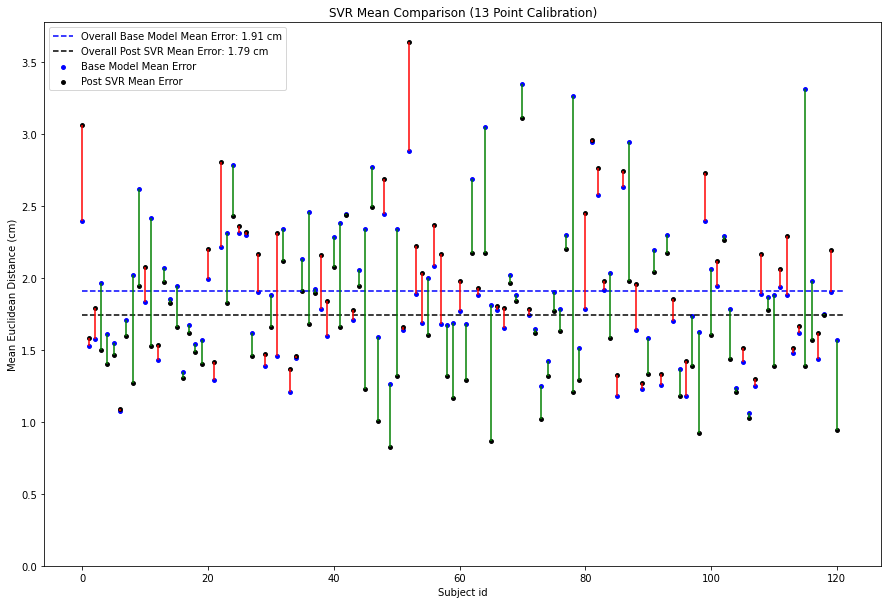

In [25]:
mean_errs_pre = []
mean_errs_final = []
for i in svr_out:
    mean_errs_pre.append(np.mean(svr_out[i][0]))
    mean_errs_final.append(np.mean(svr_out[i][1]))

plt.figure(figsize=(15,10))
plt.title('SVR Mean Comparison (13 Point Calibration)')
ctr = 0
plt.hlines(y=np.mean(mean_errs_pre), xmin=0, xmax=len(mean_errs_pre), color='b', linestyles='dashed', label="Overall Base Model Mean Error: "+str(np.round(np.mean(mean_errs_pre), 3))+" cm")
plt.hlines(y=np.median(mean_errs_final), xmin=0, xmax=len(mean_errs_pre), color='k', linestyles='dashed', label="Overall Post SVR Mean Error: "+str(np.round(np.mean(mean_errs_final), 3))+" cm")
for i in range(len(means_pre)):
    if(means_post[i]<= means_pre[i]):
        plt.vlines(x=ctr, ymin=means_post[i], ymax=means_pre[i], colors='green')
    else:
        plt.vlines(x=ctr, ymin=means_pre[i], ymax=means_post[i], colors='red')
    ctr+=1
plt.scatter([i for i in range(len(mean_errs_pre))], mean_errs_pre, s=15, label="Base Model Mean Error", color='b')
plt.scatter([i for i in range(len(mean_errs_pre))], mean_errs_final, s=15, label="Post SVR Mean Error", color='black')



plt.xlabel('Subject id')
plt.ylabel('Mean Euclidean Distance (cm)')
plt.ylim(0)
plt.legend()

## Few outputs

  0%|          | 0/10 [00:00<?, ?it/s]

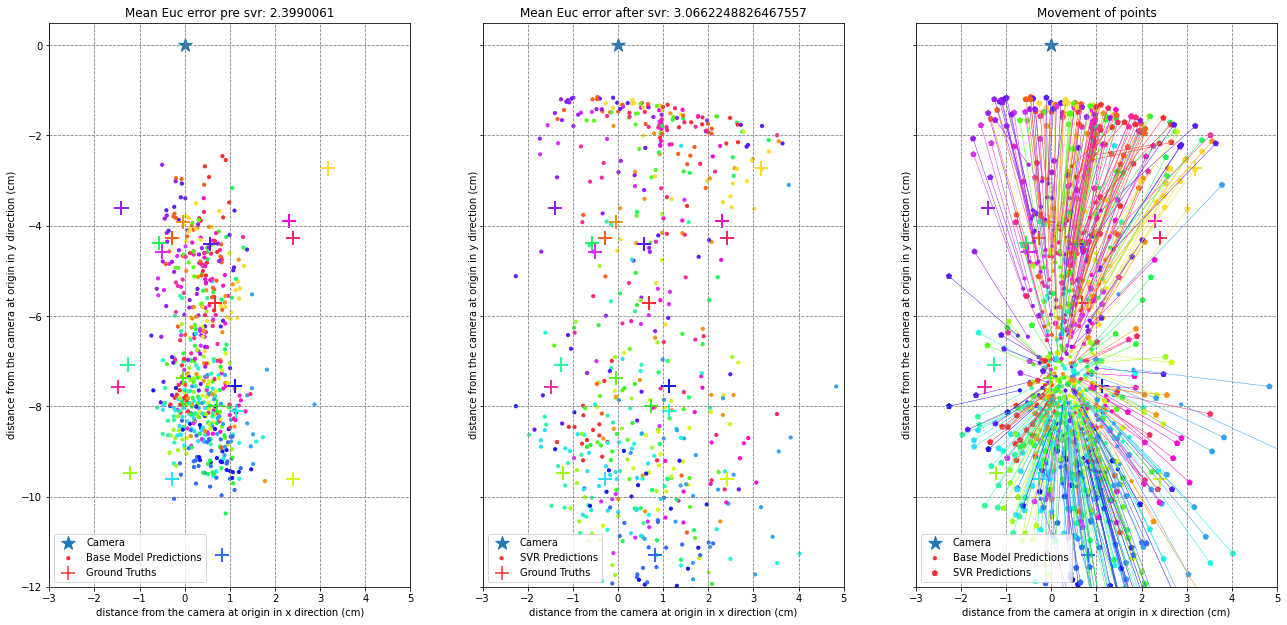

 10%|█         | 1/10 [00:00<00:08,  1.10it/s]

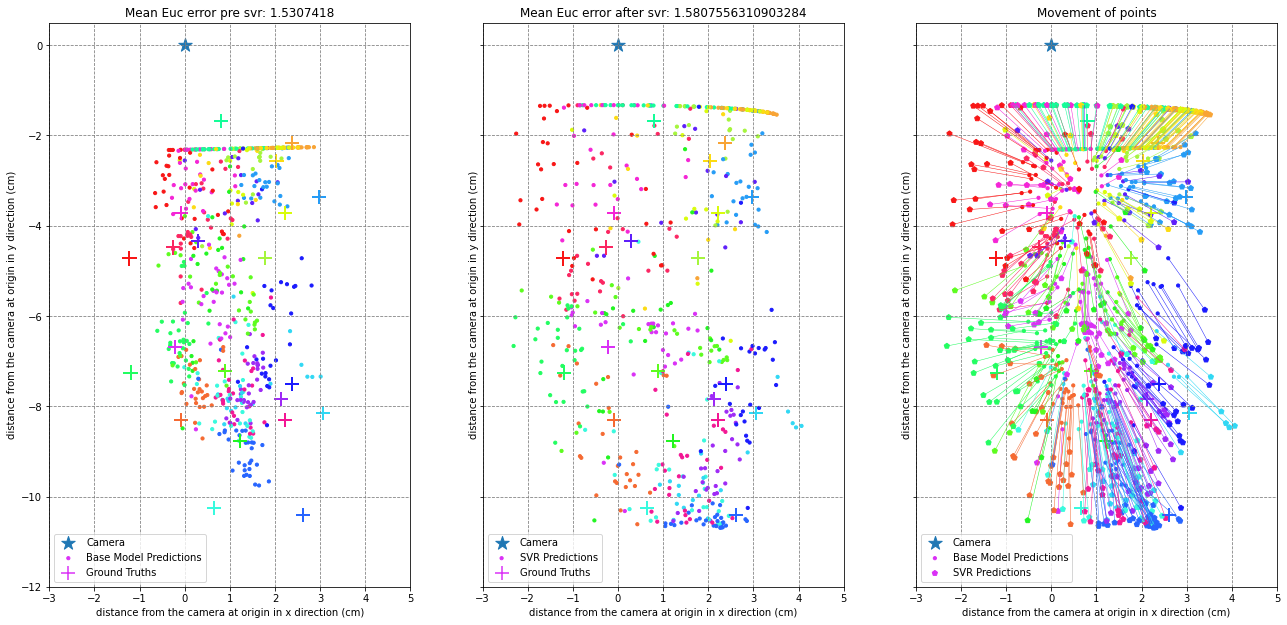

 20%|██        | 2/10 [00:01<00:07,  1.07it/s]

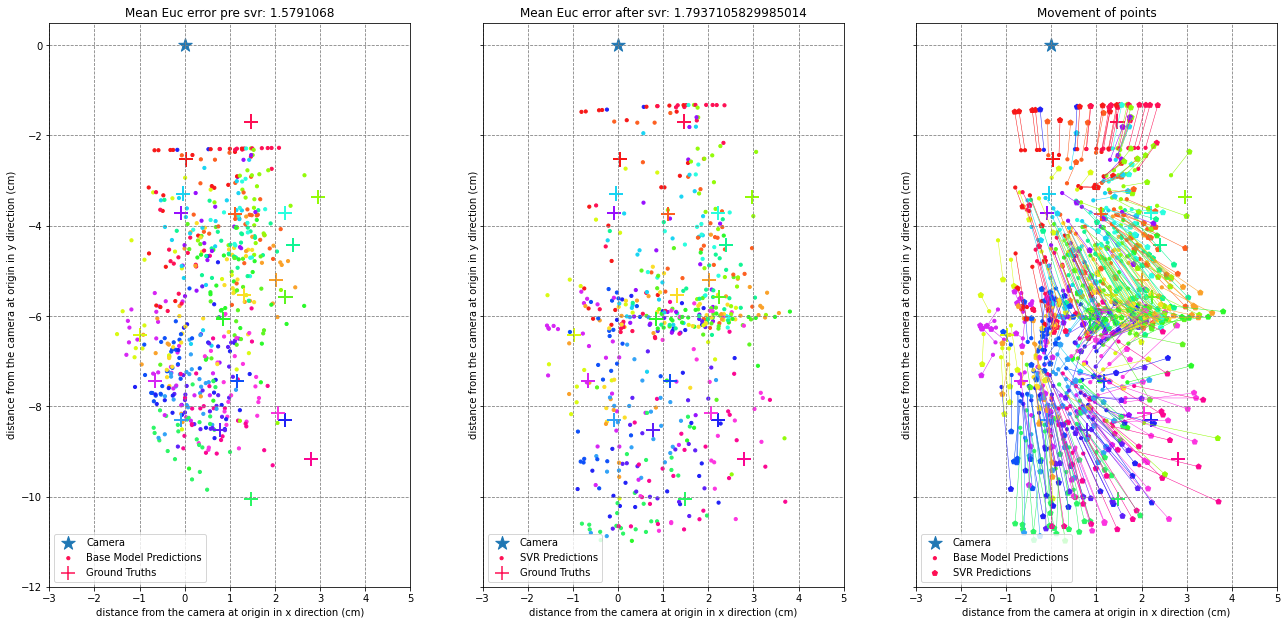

 30%|███       | 3/10 [00:02<00:06,  1.06it/s]

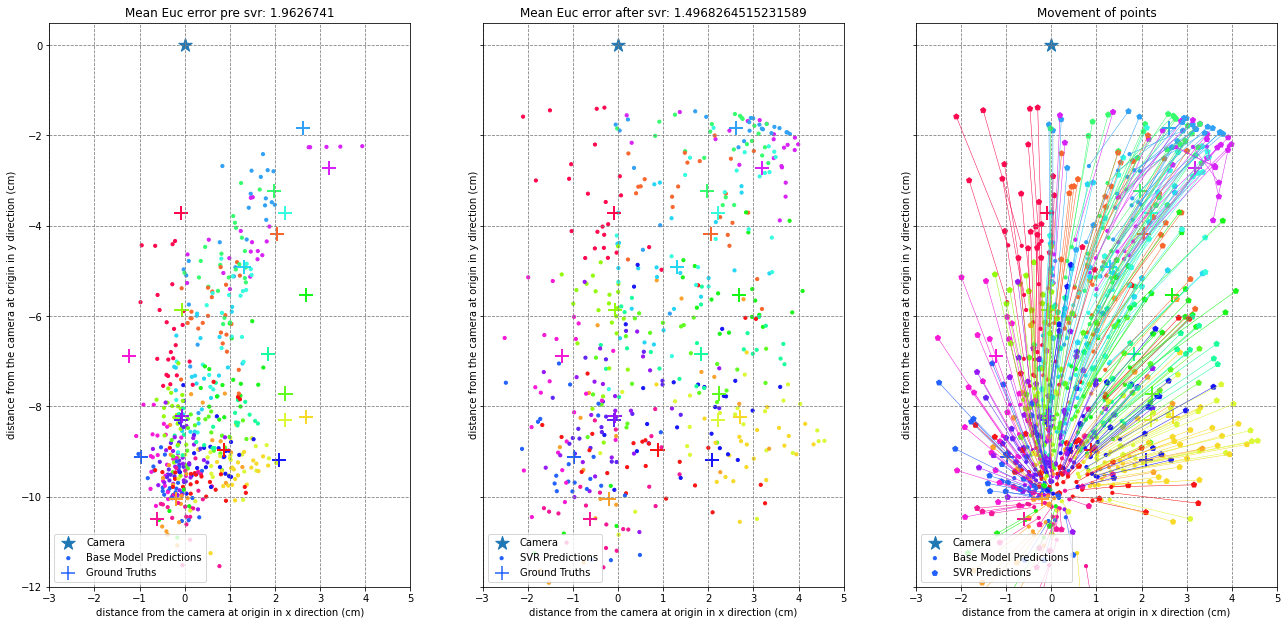

 40%|████      | 4/10 [00:03<00:05,  1.07it/s]

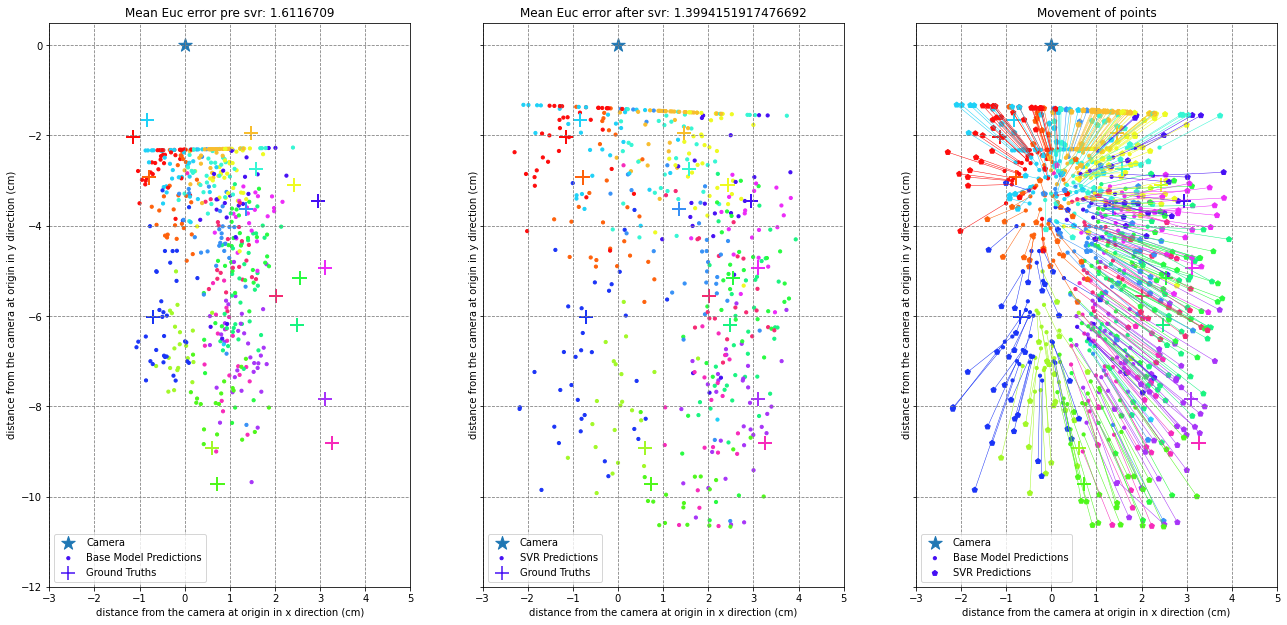

 50%|█████     | 5/10 [00:04<00:04,  1.06it/s]

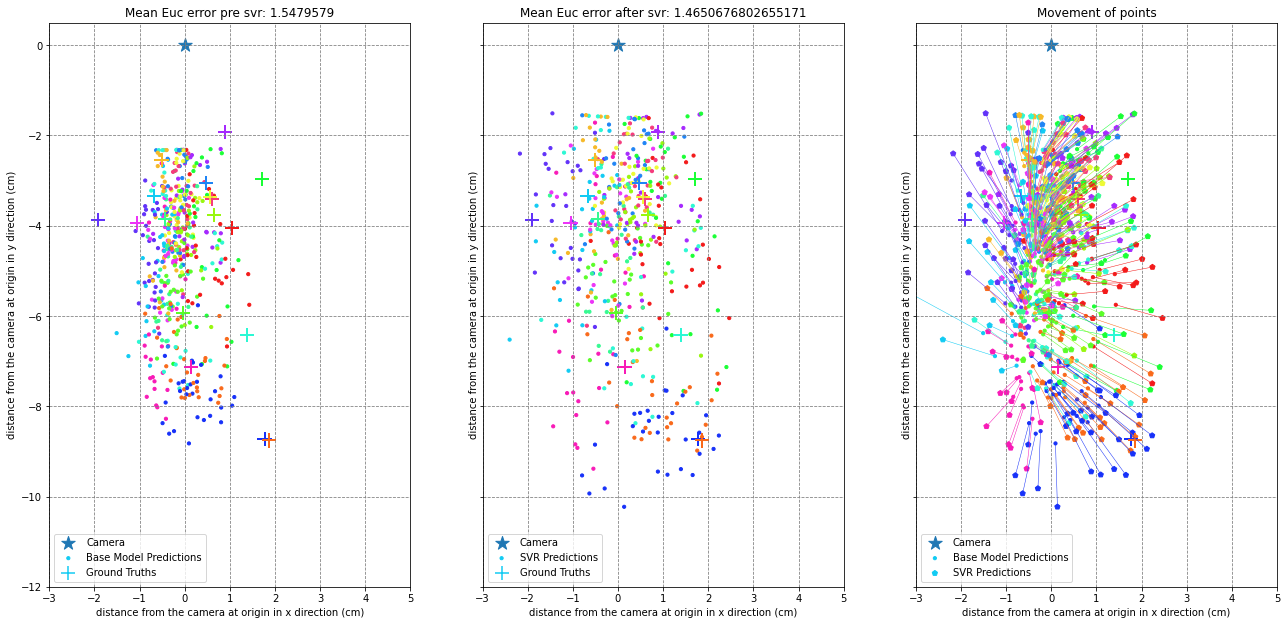

 60%|██████    | 6/10 [00:05<00:03,  1.11it/s]

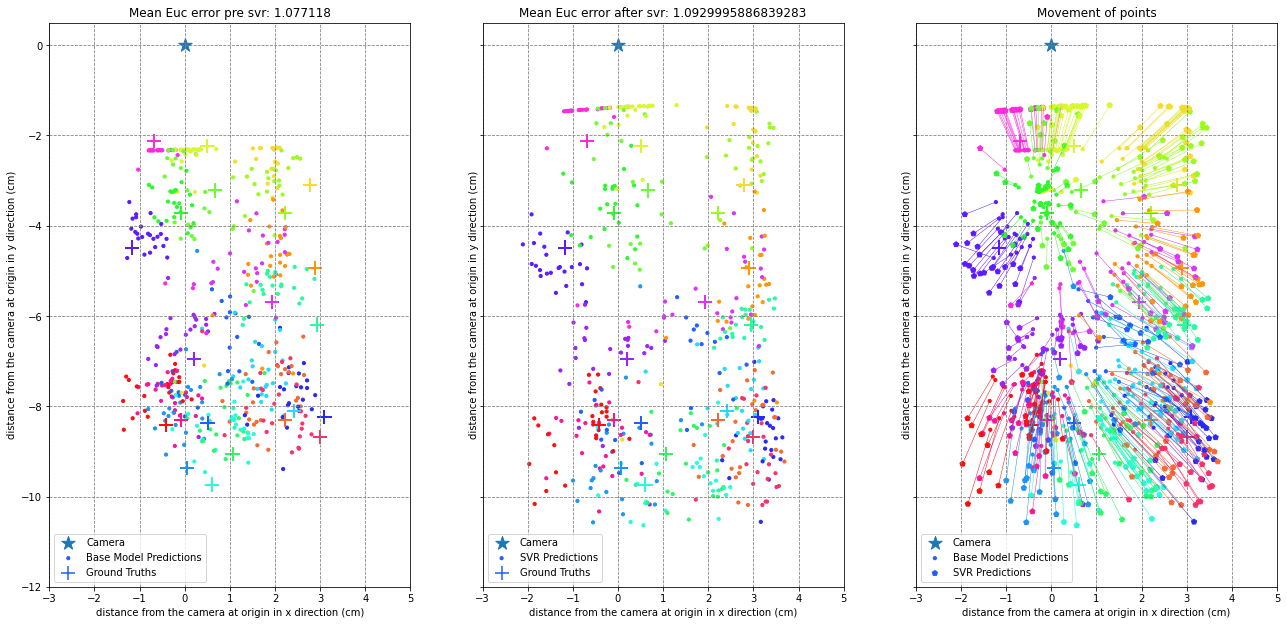

 70%|███████   | 7/10 [00:06<00:02,  1.09it/s]

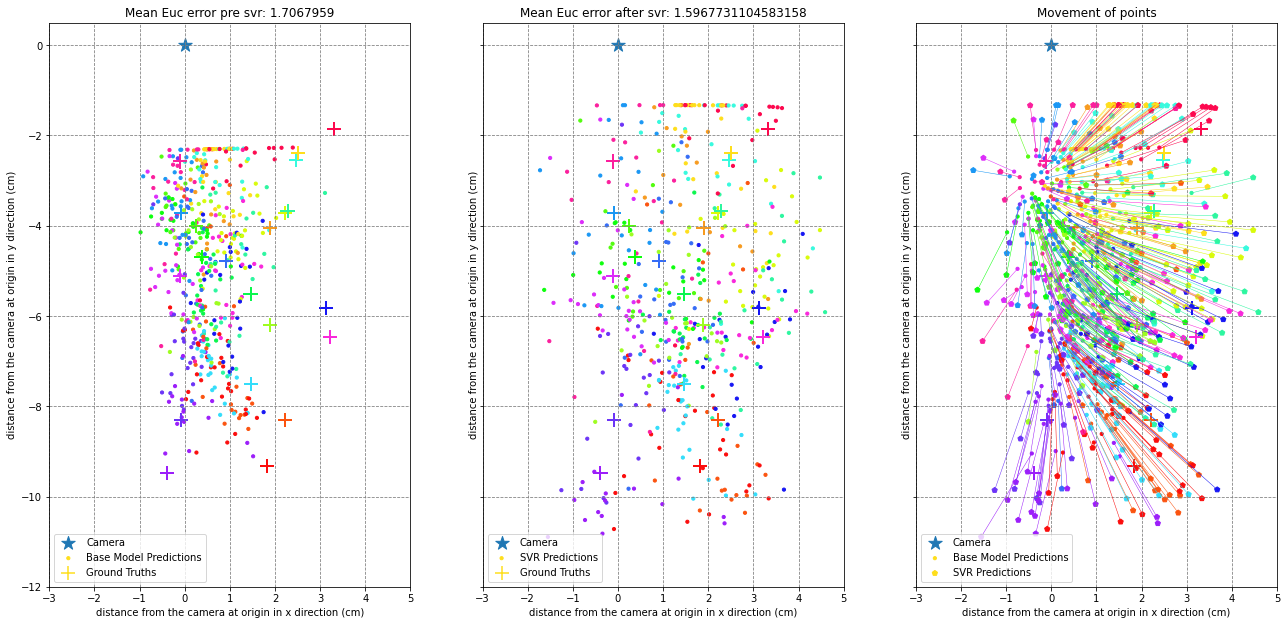

 80%|████████  | 8/10 [00:07<00:01,  1.09it/s]

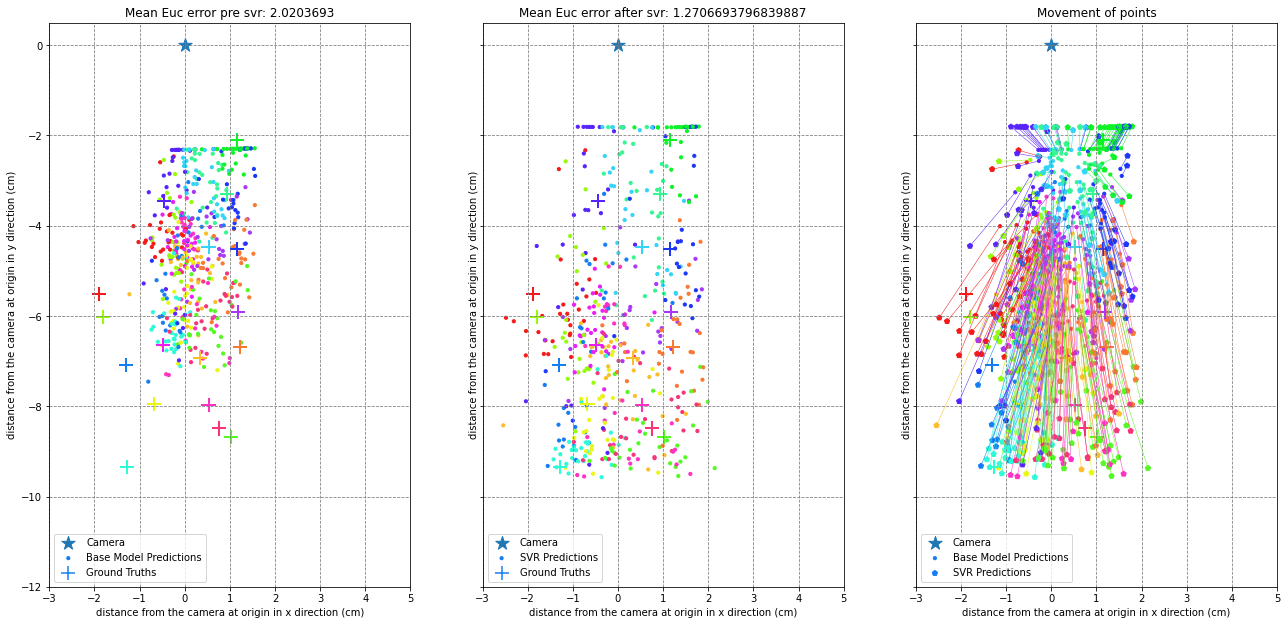

 90%|█████████ | 9/10 [00:08<00:00,  1.14it/s]

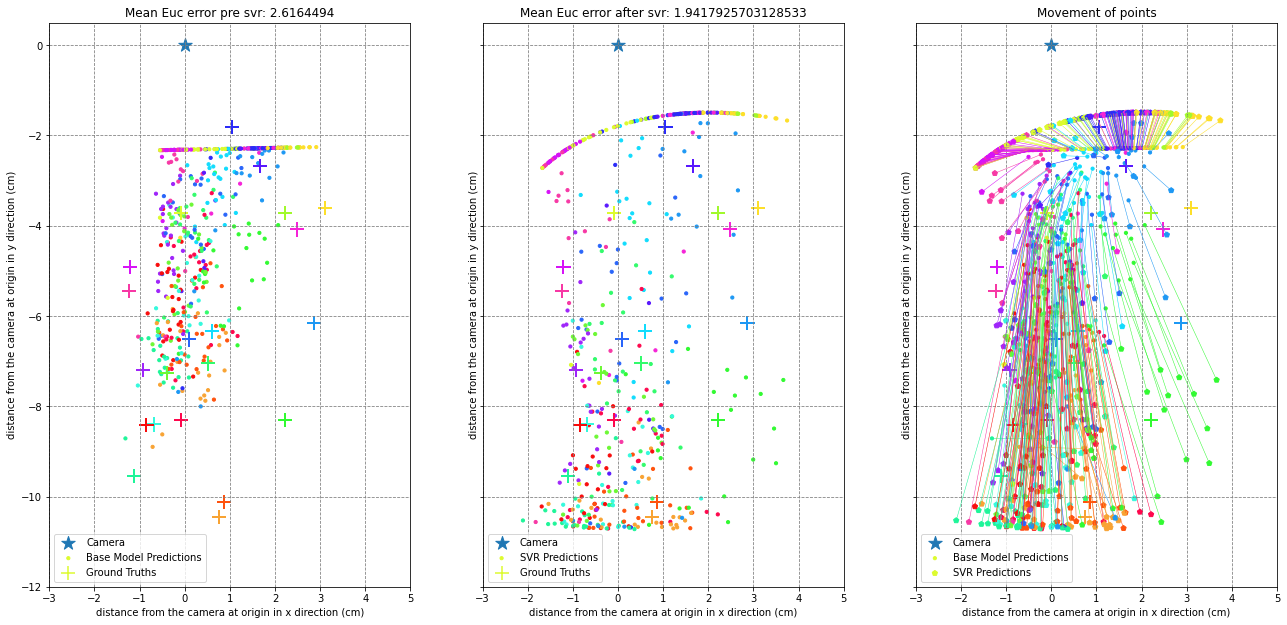

100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


In [27]:
mt = 0
for idx in tqdm(list(svr_out.keys())[:10]):
    i = idx
    plot_comp(svr_out[i][2], svr_out[i][3], svr_out[i][4], svr_out[i][5], svr_out[i][6], ['Mean Euc error pre svr: '+str(np.mean(svr_out[i][0])), 'Mean Euc error after svr: '+str(np.mean(svr_out[i][1]))], cent='none', lines=True)


# Random tests

device:  iPhone 6
id:  49
Num files:  315
Sample:


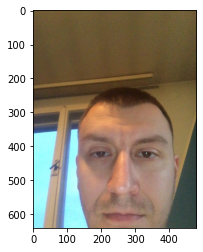

In [28]:
idx = np.random.randint(len(files))
meta = json.load(open(glob(files[idx].replace('images', 'meta')+"*.json")[0]))
print("device: ", meta['device'])
print("id: ", idx)
print("Num files: ", len(glob(files[idx]+"*.jpg")))
print("Sample:")
plt.imshow(plt.imread(glob(files[idx]+"*.jpg")[0]))

Num files for test = 315
Mean Euclidean Distance:  1.2626768
(1280, 960, 3)


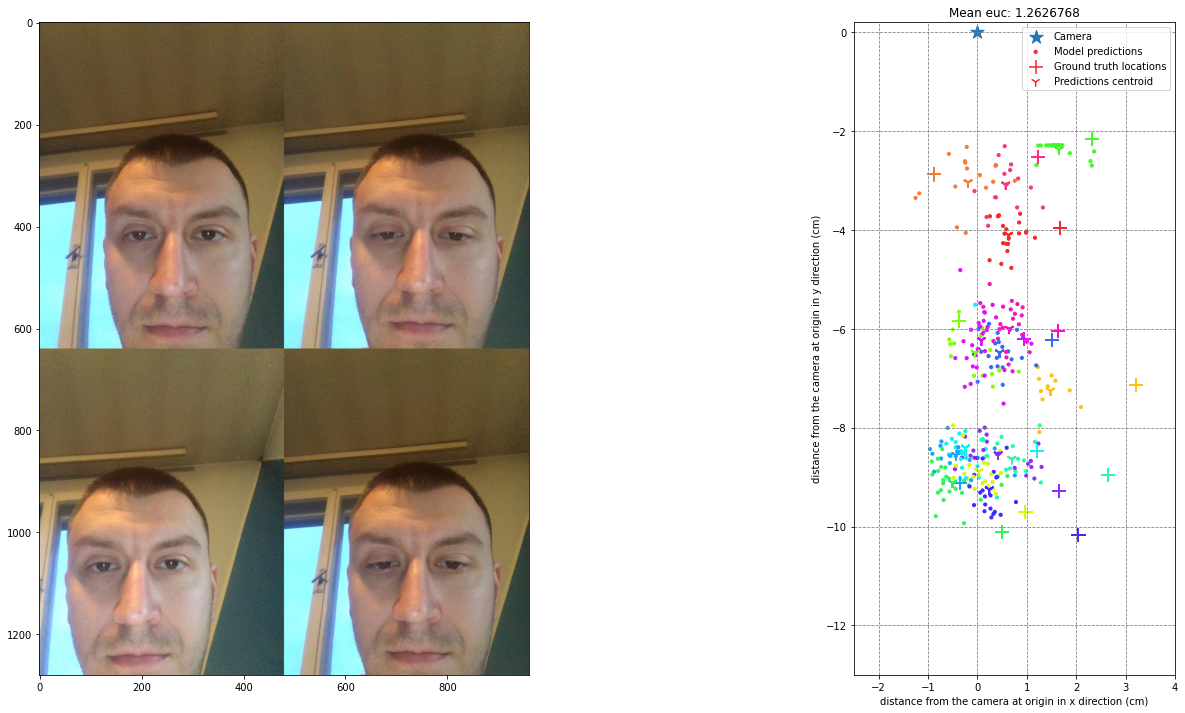

In [34]:
preds, gt = [], []
ctr = 1
f = files[idx]
fs = glob(f+"*.jpg")
test_dataset = gazetrack_dataset(f, phase='test')
test_dataloader = DataLoader(test_dataset, batch_size=256, num_workers=10, pin_memory=False, shuffle=False,)

preds, gt = [], []
for j in test_dataloader:
    leye, reye, kps, target = j[1].cuda(), j[2].cuda(), j[3].cuda(), j[4].cuda()

    with torch.no_grad():
        pred = model(leye, reye, kps)
    pred = pred.cpu().detach().numpy()
    preds.extend(pred)  

    gt.extend(target.cpu().detach().numpy())

preds = np.array(preds)
pts = np.unique(gt, axis=0)

c = get_colors(len(pts))
random.shuffle(c)

gt = np.array(gt)
dist = euc(preds, gt)
print("Mean Euclidean Distance: ", dist.mean())
plot_pts(f, gt, preds, pts, c, "Mean euc: "+str(dist.mean()), cent=True)